# Image normalization and scattering correction

## Load the needed modules

We first need to load some modules to work with this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import amglib.readers as rd
import amglib.bb as bb
from skimage.measure import label, regionprops
import pandas as pd
import skimage.morphology as morph
import skimage.filters as filt
from skimage.feature import match_template
from skimage.draw import disk

import tifffile as tiff

The reload is mainly for the development of the support modules used in this notebook.

In [2]:
import importlib
importlib.reload(rd)
importlib.reload(bb)

<module 'amglib.bb' from '/Users/kaestner/git/scripts/python/notebooks/../amglib/bb.py'>

## Load some test images
In this notebook we will work with the following images.

In [39]:
img  = rd.readImage('../../../TestData/2D/fits/BB/sample_0001.fits') 
dc   = rd.readImage('../../../TestData/2D/fits/BB/dc_00001.fits')
ob   = rd.readImage('../../../TestData/2D/fits/BB/ob_00001.fits')
bbs  = rd.readImage('../../../TestData/2D/fits/BB/bbsample_00001.fits')
bbob = rd.readImage('../../../TestData/2D/fits/BB/bbob_00001.fits')

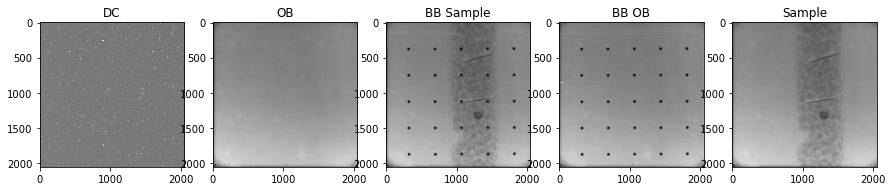

In [40]:
fig, ax = plt.subplots(1,5, figsize=(15,5))

vmin = 300
vmax = 10000
cmap = 'gray'
ax[0].imshow(dc,   vmin=200,vmax=400,   cmap=cmap); ax[0].set_title('DC')
ax[1].imshow(ob,   vmin=vmin,vmax=vmax, cmap=cmap); ax[1].set_title('OB')
ax[2].imshow(bbs,  vmin=vmin,vmax=vmax, cmap=cmap); ax[2].set_title('BB Sample')
ax[3].imshow(bbob, vmin=vmin,vmax=vmax, cmap=cmap); ax[3].set_title('BB OB')
ax[4].imshow(img,  vmin=vmin,vmax=vmax, cmap=cmap); ax[4].set_title('Sample');

# Normalization
The basic normalization of images is done using the folowing expression:

$$T=\frac{Img-DC}{OB-DC}$$

It is expected that the image intensity is equal to one in areas that are not covered by any material.

This does not hold when the source intensity is varying between the images. The source is mostly flucuating to some degree, therefore it is good practice to include a dose correction factor 

$$T_{dose}=\frac{D(OB,roi)}{D(Img,roi)}\frac{Img-DC}{OB-DC}$$

where the dose is computed as the average intensity of a region which is not covered by any material. The average is senitive to outliers. The median of the region can be used to make the dose calculation more robust against outliers, or like here the average of medians:

$$D(f,roi)=mean[median_{rows}[f(roi)]]$$


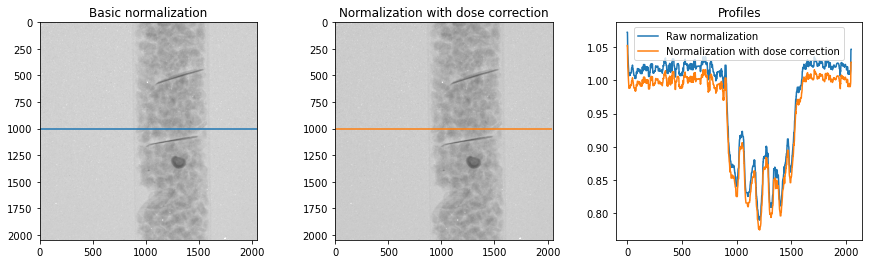

In [41]:
nimg = bb.normalize(img,ob,dc, logarithm=False)
N=25
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].imshow(nimg,vmin=0,vmax=1.25,cmap='gray')
ax[0].set_title('Basic normalization')
ax[0].hlines(1000,xmin=0,xmax=2047,color=colors[0])
nimg_dose = bb.normalize(img,ob,dc, dose_roi = [500,500,550,550], logarithm=False)
ax[1].imshow(nimg_dose,vmin=0,vmax=1.25,cmap='gray')
ax[1].set_title('Normalization with dose correction')
ax[1].hlines(1000,xmin=0,xmax=2047,color=colors[1])

ax[2].plot(filt.median(nimg[1000],np.ones(N)),label='Raw normalization')
ax[2].set_title('Profiles')

ax[2].plot(filt.median(nimg_dose[1000],np.ones(N)),label='Normalization with dose correction')
ax[2].legend();

You can barely see any difference between the normalized images. When you look at the line profiles you can however see that there actually is a difference in the transmission value of between the two images. The one without dose correction has about 1.02 in the open beam area, which is not physically correct. After the dose correction, you can see that the average intensit in air is about one, but the air profile is not perfectly straight. There is a slight increse close to the sample. This is a phenomenon we will handle in the next section.

# Improving the quality of the normalization

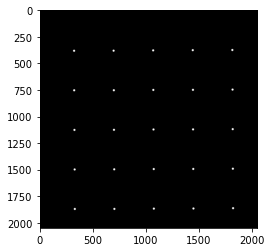

In [42]:
mask,r,c,regions = bb.get_black_bodies(bbob, greythres = 2000, areas=[500,1000],R=10)
plt.imshow(mask, cmap=cmap)


In [43]:
regions.head()

,label,mean,median,r,c
0,5,783.424072,765.0,375.328377,1806.691450
1,6,749.322693,739.0,376.926014,1434.840095
2,7,787.472839,739.0,378.908362,1062.872852
3,8,867.858948,777.0,382.247561,319.890244
4,9,817.697754,760.0,381.753939,691.075152


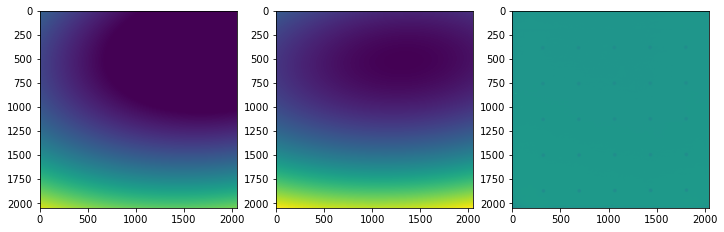

In [44]:
sob=bb.compute_scatter_image(bbob-dc,r,c)
ss=bb.compute_scatter_image(bbs-dc,r,c)
fig,ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(sob, vmin=ss.min(),vmax=ss.max())
ax[1].imshow(ss)
ax[2].imshow(bbob-dc-sob)

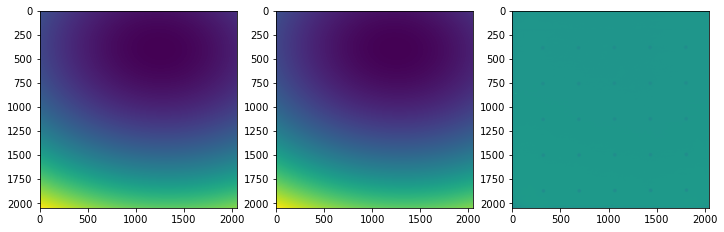

In [45]:
sob=bb.compute_scatter_image_from_df(regions,img.shape)
ss=bb.compute_scatter_image_from_df(regions,img.shape)
fig,ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(sob, vmin=ss.min(),vmax=ss.max())
ax[1].imshow(ss)
ax[2].imshow(bbob-dc-sob)

## Detect dots

In [46]:
a=bbs-dc

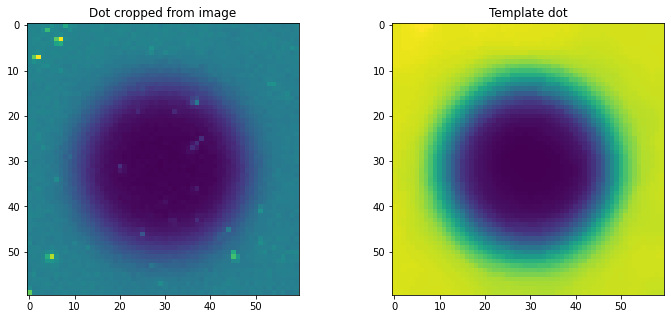

In [47]:
fig,ax=plt.subplots(1,2,figsize=(12,5))

ax[0].imshow(a[350:410,290:350])
ax[0].set_title('Dot cropped from image')
template=bb.get_dot_template((bbs-dc),roi=[350,290,410,350])
ax[1].imshow(template)
ax[1].set_title('Template dot');

## Estimate OB scattering image

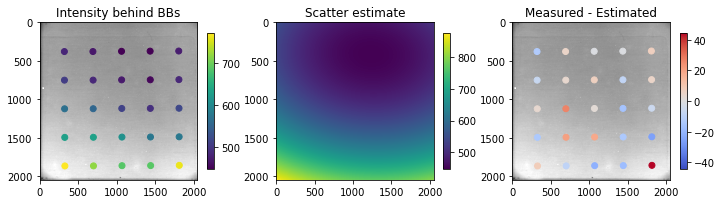

In [48]:
obmask,r,c,bbdf = bb.get_blackbodies_by_templatematching(bbob-dc,template,0.5)

obest=bb.compute_scatter_image_from_df(bbdf,obmask.shape)

cmap = 'coolwarm'
fig,ax=plt.subplots(1,3,figsize=(12,5))
df=bb.check_scatter_image(bbob-dc,0,obmask,ax=ax[0],cmap='viridis')
ax[0].set_title('Intensity behind BBs')
a1=ax[1].imshow(obest,cmap='viridis')
ax[1].set_title('Scatter estimate')
fig.colorbar(a1,ax=ax[1],shrink=0.5)
df=bb.check_scatter_image(bbob-dc,obest,obmask,ax=ax[2],cmap=cmap,sym_cmap=True)
ax[2].set_title('Measured - Estimated');

## Estimate scattering image with sample

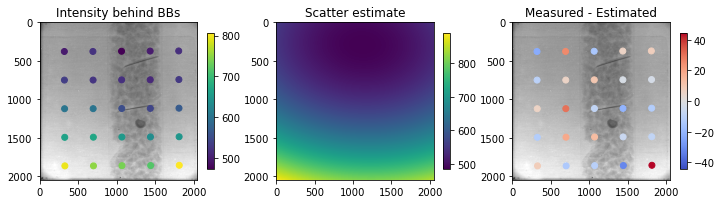

In [49]:
smask,r,c,sdf   = bb.get_blackbodies_by_templatematching(bbs-dc,template,0.5)
sest=bb.compute_scatter_image_from_df(sdf,smask.shape)

cmap = 'coolwarm'
fig,ax=plt.subplots(1,3,figsize=(12,5))
df=bb.check_scatter_image(bbs-dc,0,smask,ax=ax[0],cmap='viridis')
ax[0].set_title('Intensity behind BBs')
a1=ax[1].imshow(sest,cmap='viridis')
ax[1].set_title('Scatter estimate')
fig.colorbar(a1,ax=ax[1],shrink=0.5)
df=bb.check_scatter_image(bbs-dc,sest,smask,ax=ax[2],cmap=cmap,sym_cmap=True)
ax[2].set_title('Measured - Estimated');

## Normalization with scattering correction

$$\frac{\tilde{I}_n}{\tilde{I}_{OB}}=\frac{I_n}{I_{OB}}\cdot\frac{D(I_{OB})}{D(I_{n})}=\frac{I_{n}^{*}-I_{DC}-I_{n,BB}^{S}\frac{D\left(I_{n}^{*}-I_{DC}\right)}{D\left(I_{n,BB}^{*}-I_{DC}-\left(1-\frac{1}{\tau_{BB}}\right)I_{n,BB}^{S}\right)\tau_{BB}}}{I_{OB}^{*}-I_{DC}-I_{BG,BB}^{S}\frac{D\left(I_{OB}^{*}-I_{DC}\right)}{D\left(I_{OB,BB}^{*}-I_{DC}-\left(1-\frac{1}{\tau_{BB}}\right)I_{BG,BB}^{S}\right)\tau_{BB}}}\cdot\frac{D\left(I_{OB}^{*}-I_{DC}-I_{BG,BB}^{S}\frac{D\left(I_{OB}^{*}-I_{DC}\right)}{D\left(I_{OB,BB}^{*}-I_{DC}-\left(1-\frac{1}{\tau_{BB}}\right)I_{BG,BB}^{S}\right)\tau_{BB}}\right)}{D\left(I_{n}^{*}-I_{DC}-I_{n,BB}^{S}\frac{D\left(I_{n}^{*}-I_{DC}\right)}{D\left(I_{n,BB}^{*}-I_{DC}-\left(1-\frac{1}{\tau_{BB}}\right)I_{n,BB}^{S}\right)\tau_{BB}}\right)}$$

In [51]:
# Projection normalized with dose correction
nimg_dose = bb.normalize(img,ob,dc, dose_roi = [500,500,550,550], logarithm=False)

# Projection normalized with scattering correction
nimg_sc   = bb.normalization_with_BB(img,ob,dc,bbs,bbob,sest,obest,[500,500,550,550],0.97)

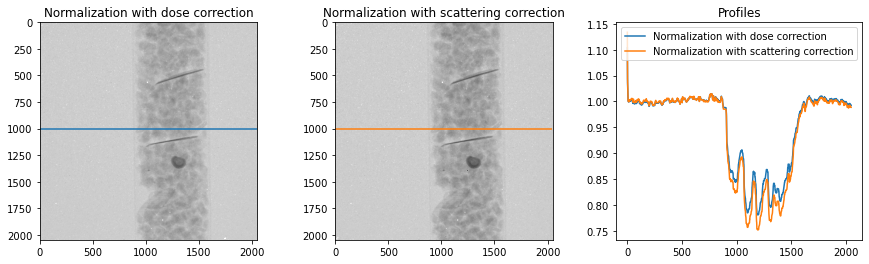

In [52]:
# Visualization 
N=25
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].imshow(nimg_dose,vmin=0,vmax=1.25,cmap='gray')
ax[0].set_title('Normalization with dose correction')
ax[0].hlines(1000,xmin=0,xmax=2047,color=colors[0])

ax[1].imshow(nimg_sc,vmin=0,vmax=1.25,cmap='gray')
ax[1].set_title('Normalization with scattering correction')
ax[1].hlines(1000,xmin=0,xmax=2047,color=colors[1])

ax[2].plot(filt.median(nimg_dose[1000:1010].mean(axis=0), np.ones(N)),  label='Normalization with dose correction')
ax[2].plot(filt.median(nimg_sc[1000:1010].mean(axis=0),   np.ones(N)),  label='Normalization with scattering correction')

ax[2].set_title('Profiles')

ax[2].legend();

## Special case: The BB grid is present in all images

In this we set $I_{n}^{*}=I_{n,BB}^{*}$ in the previous equation. This is a minor modification that can be handled by the ```bb.normalization_with_BB``` function.

In [54]:
nimg_sc_BBin = bb.normalization_with_BB(bbs,ob,dc,bbs,bbob,sest,obest,[500,500,550,550],0.97)

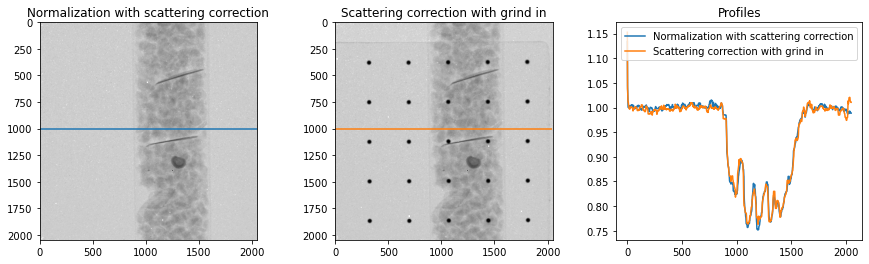

In [57]:
# Visualization 
N=25
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].imshow(nimg_sc,vmin=0,vmax=1.25,cmap='gray')
ax[0].set_title('Normalization with scattering correction')
ax[0].hlines(1000,xmin=0,xmax=2047,color=colors[0])

ax[1].imshow(nimg_sc_BBin,vmin=0,vmax=1.25,cmap='gray')
ax[1].set_title('Scattering correction with grind in')
ax[1].hlines(1000,xmin=0,xmax=2047,color=colors[1])

ax[2].plot(filt.median(nimg_sc[1000:1010].mean(axis=0), np.ones(N)),  label='Normalization with scattering correction')
ax[2].plot(filt.median(nimg_sc_BBin[1000:1010].mean(axis=0),   np.ones(N)),  label='Scattering correction with grind in')

ax[2].set_title('Profiles')

ax[2].legend();

There is a slight difference between the profiles. This is mainly due to the fact that the case with grid in uses exacly same image twice.

# Workbench

In [68]:
import importlib
importlib.reload(rd)
importlib.reload(bb)

<module 'amglib.bb' from '/Users/kaestner/git/scripts/python/notebooks/../amglib/bb.py'>

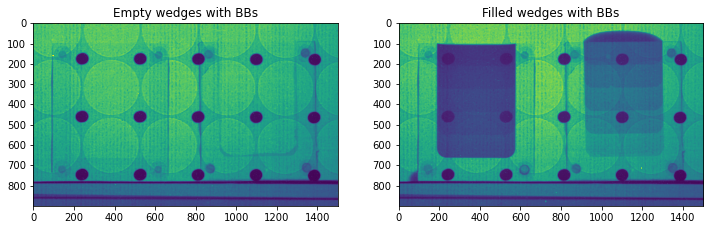

In [61]:
dc    = tiff.imread('../../../TestData/2D/tiff/stepwedge/exp60s_dc.tif')
bbob  = tiff.imread('../../../TestData/2D/tiff/stepwedge/exp60s_bbempty.tif')
bbs   = tiff.imread('../../../TestData/2D/tiff/stepwedge/exp60s_bbh2o.tif')

bbob = bbob - dc
bbs  = bbs  - dc

bbob[bbob<1] = 1
bbs[bbs<1]   = 1

fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].imshow(bbob,vmin=300,vmax=20000)
ax[0].set_title('Empty wedges with BBs')

ax[1].imshow(bbs,vmin=300,vmax=20000)
ax[1].set_title('Filled wedges with BBs');

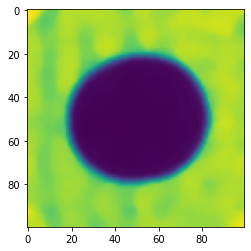

In [62]:
dot = bb.get_dot_template(bbob,roi=[410,190,510,290]) 
plt.imshow(dot)

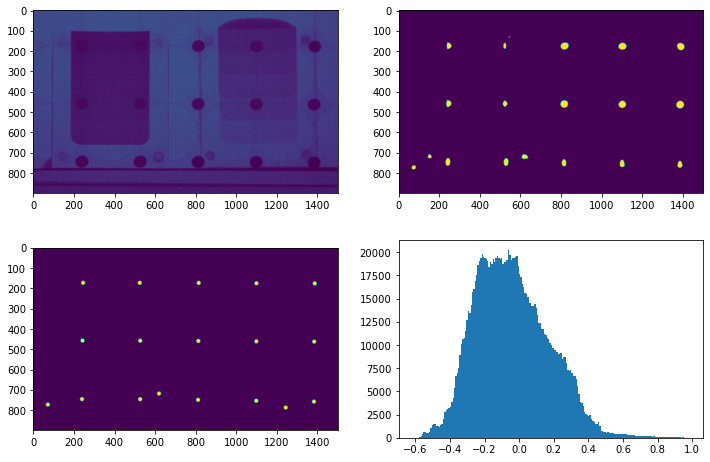

In [101]:
mbbob,rob,cob,dfob,tm=bb.get_blackbodies_by_templatematching(bbs,dot,threshold=0.4,R=10,area_th=[0.2,0.8])
# Display results
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax=ax.ravel()

ax[0].imshow(bbs)
ax[1].imshow(0.50<tm)
ax[2].imshow(mbbob)
ax[3].hist(tm.ravel(),bins=200);

In [98]:
ttm = 0.5<tm
lbl = label(ttm)

areas = []
val = []
for idx in np.arange(1,lbl.max()+1) :
    areas.append(ttm[lbl==idx].sum())
    val.append(np.median(bbs[lbl==idx]))
    
dot_area=(dot<filt.threshold_otsu(template)).sum()
areas = np.array(areas)
val = np.array(val)

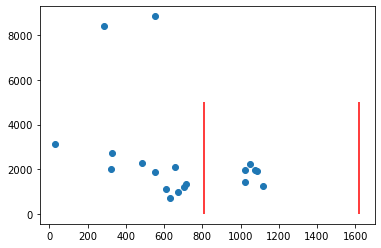

In [97]:
plt.scatter(areas,val)
area_th=[0.3,0.6]
plt.vlines([dot_area*area_th[0],dot_area*area_th[1]],ymin=0,ymax=5000,color='r')

In [100]:
(600<areas).sum()

12

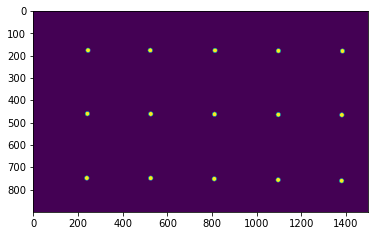

In [102]:
mask = mbbob
mask[:,:200]=0
mask[:,580:700]=0
mask[:,1200:1300]=0
plt.imshow(mask)

In [103]:
mask.dtype

dtype('uint8')

In [105]:
tiff.imwrite('bb_masked.tif',mask)

In [8]:
if 1 == 0 :
    a=0
else :
    a=1

In [9]:
a

1